In [253]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from joblib import dump, load
import pandas as pd

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *
from flows.flows import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [255]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Simple

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0    # bkgd: normal(-0.1, 1)     sgnl: normal(0.1, 1)
reps = 20

# File parameters
dirstr = 'models/univariate/simple/ab_mse/set_{}/'.format(num)
filestr = dirstr + 'model_{}_{}.h5'

if not os.path.isdir(dirstr):
    os.mkdir(dirstr)

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)
ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(dirstr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_simple.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0 
reps = 20

# Model parameters
dirstr = 'models/univariate/simple/ab_sqr/set_{}/'.format(num)
filestr_1 = dirstr + 'relu/model_{}_{}.h5'
filestr_2 = dirstr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(dirstr + 'lin_avgs.npy')
exp_avgs = np.load(dirstr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_simple.png', 
            dpi=300, 
            bbox_inches='tight')

## Landscapes

### All

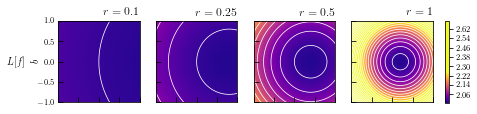

In [231]:
rs = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (7, h - 0.45))
axs[0].set_ylabel(r'$b$', labelpad = -3)
axs[0].text(-2.25, -0.07, r'$L[f]$')

cplots = [None] * 4
aa = np.load('anims/sqr/aa.npy')
bb = np.load('anims/sqr/bb.npy')
for i in range(len(rs)):
    r = rs[i]
    zz_loss = np.load('anims/sqr/zz_{}.npy'.format(r))
    loss_contours = np.arange(1, 3.1, 0.025)
    
    cplots[i] = axs[i].contourf(aa, bb, zz_loss, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25, zorder = -2)
    axs[i].contour(aa, bb, zz_loss, levels = loss_contours, colors = 'white', linewidths = 0.75, zorder = -1)
    axs[i].set_title(r'$r = {}$'.format(r), loc = 'right')
    axs[i].set_aspect('equal')
    
    axs[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    axs[i].set_xticklabels([])
    axs[i].tick_params(axis = 'y', which = 'minor', bottom = False)
    axs[i].tick_params(axis = 'x', which = 'minor', bottom = False)
    axs[i].tick_params(direction='in', which='both',length=5)

#fig.tight_layout()
    
fig.colorbar(cplots[3], ax = axs.ravel(), ticks = np.arange(1.98, 2.7, 0.08), 
             fraction = 0.01045, pad = 0.03);

plt.savefig('plots/paper/simple/sqr_loss.pdf', 
            dpi=300, 
            bbox_inches='tight')

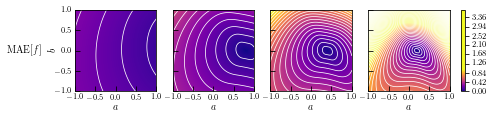

In [409]:
rs = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (7, 3.25 - 0.45))
axs[0].set_ylabel(r'$b$', labelpad = -3)
axs[0].text(-2.66, -0.07, r'${\rm MAE}[f]$')

cplots = [None] * 4
aa = np.load('anims/sqr/aa.npy')
bb = np.load('anims/sqr/bb.npy')
for i in range(len(rs)):
    r = rs[i]
    zz_maes = np.load('anims/sqr_mae/normal/0/zz_{}.npy'.format(r))
    maes_contours = np.arange(0, 7, 0.05)
    
    cplots[i] = axs[i].contourf(aa, bb, zz_maes, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1, zorder = -2)
    axs[i].contour(aa, bb, zz_maes, levels = maes_contours, colors = 'white', linewidths = 0.75, zorder = -1)
    #axs[i].set_title(r'$r = {}$'.format(r), loc = 'right')
    axs[i].set_aspect('equal')
    
    axs[i].set_xlabel('$a$', labelpad = 1)
    axs[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    axs[i].tick_params(axis = 'y', which = 'minor', bottom = False)
    axs[i].tick_params(axis = 'x', which = 'minor', bottom = False)
    axs[i].tick_params(direction='in', which='both',length=5)

#fig.tight_layout()
    
fig.colorbar(cplots[3], ax = axs.ravel(), ticks = np.arange(0, 3.71, 0.42), 
             fraction = 0.01045, pad = 0.03);

plt.savefig('plots/paper/simple/sqr_maes.pdf', 
            dpi=300, 
            bbox_inches='tight')

### Loss

In [107]:
hh = 1.75

In [108]:
dirstr = 'anims/sqr/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(1, 3.1, 0.02)

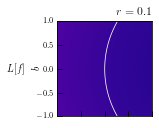

In [132]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
#plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(1.98, 2.02, 0.004))
plt.text(-2.05, -0.07, '$L[f]$')
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.set_title(r'$r = {}$'.format(r), loc = 'right')
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels([])
ax.tick_params(axis = 'y', which = 'minor', bottom = False)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.colorbar(ticks = np.arange(1.98, 2.7, 0.08))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

### MAE

In [ ]:
dirstr = 'anims/sqr_mae/normal/0/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(0, 7, 0.05)

In [ ]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
#plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(0.06, 0.28, 0.02))
plt.text(-1.8, -1.3, r'(b) Contour Plots of MAE$[f]$', rotation = 'vertical')
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.tick_params(axis = 'y', which = 'minor', bottom = False)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)
ax.set_xlabel(r'$a$')

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.colorbar(ticks = np.arange(0, 3.71, 0.42))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

# Normal

## Naïve Implementation

In [160]:
# Experiment parameters
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mpe = make_mpe(bkgd, sgnl, 'data/normal/0.1/')

### Likelihood Ratios

#### Process

#### Plot

In [161]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [162]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']

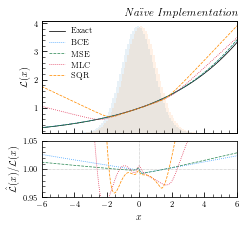

In [163]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           cs = cs, 
           lss = lss,
           title = r'\it Na\"ive Implementation',
           filename = 'plots/paper/normal/naive_fit.pdf')

### MAEs

#### Process

#### Plot

In [203]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

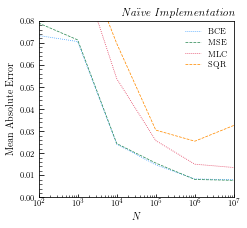

In [204]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'\it Na\"ive Implementation',
         filename = 'plots/paper/normal/naive_sizes.pdf')

## $C$ Parametrization

### BCE $C$ Parametrization

In [164]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

w = 3.5
h = 3.25              # Plots have dimension (w,h)

#### Process

#### Likelihood Ratios

In [165]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [166]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']

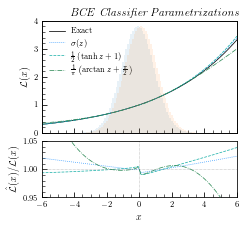

In [167]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'\it BCE Classifier Parametrizations',
           filename = 'plots/paper/normal/c_bce.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [168]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [169]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

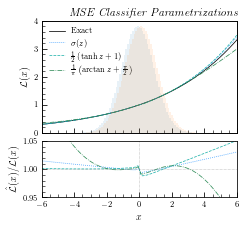

In [170]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'\it MSE Classifier Parametrizations',
           filename = 'plots/paper/normal/c_mse.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [171]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [172]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

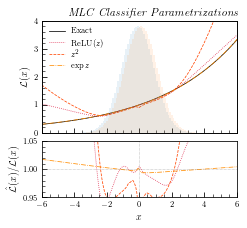

In [173]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'\it MLC Classifier Parametrizations',
           filename = 'plots/paper/normal/c_mlc.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [174]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [175]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

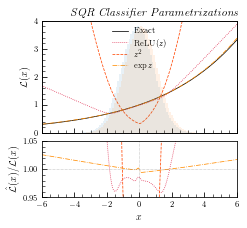

In [176]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'\it SQR Classifier Parametrizations',
           filename = 'plots/paper/normal/c_sqr.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## Generalized Loss Families

### SQR $A/B$ Parametrization

In [205]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [206]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.5]), array([0.018]))

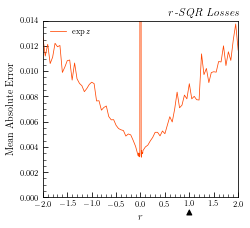

In [258]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
plt.yticks(np.arange(0, 0.022, 0.002))
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
plt.ylim(0, 0.014)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, -0.001), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $r$-SQR Losses", loc="right");
plt.savefig('plots/paper/normal/ab_sqr.pdf', 
            dpi=300, 
            bbox_inches='tight')

### MSE $A/B$ Parametrization

In [295]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [260]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.08])

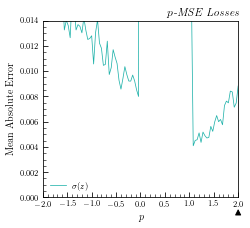

In [296]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 0.014)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.001), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $p$-MSE Losses",loc="right");
plt.savefig('plots/paper/normal/ab_mse.pdf', 
            dpi=300, 
            bbox_inches='tight')

## Optimized Implementation

In [177]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
lr = make_lr(bkgd, sgnl)

# Model parameters
p = 1.24
r = 0.018
bce_params = {'loss':bce}
mse_params = {'loss':mse}
pmse_params = {'loss':get_mse(p)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}
rsqr_params = {'loss':get_exp_sqr(r), 'output':'linear'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

pmse_filestr = filestr + 'pmse/model_{}_{}.h5'
rsqr_filestr = filestr + 'rsqr/model_{}_{}.h5'

### Likelihood Ratios

#### Process

#### Plot

In [178]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')
pmse_preds = np.load(filestr + 'pmse_preds.npy')
rsqr_preds = np.load(filestr + 'rsqr_preds.npy')

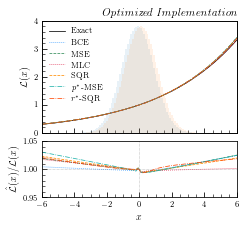

In [179]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange', 'lightseagreen', 'orangered']
lss = [':', '--', ':', '--', '-.', '-.']
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds, pmse_preds, rsqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR', r'$p^*$-MSE', r'$r^*$-SQR'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'\it Optimized Implementation',
           filename = 'plots/paper/normal/best_fit.pdf')

### MAEs

#### Process

#### Plot

In [200]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')
pmse_avg = np.load(filestr + 'pmse_avg.npy')
rsqr_avg = np.load(filestr + 'rsqr_avg.npy')

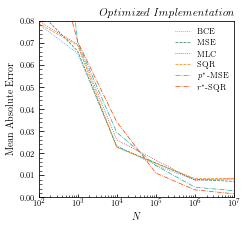

In [201]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange', 'lightseagreen', 'orangered']
lss = [':', '--', ':', '--', '-.', '-.']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg, pmse_avg, rsqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR', r'$p^*$-MSE', r'$r^*$-SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'\it Optimized Implementation',
         filename = 'plots/paper/normal/best_sizes.pdf')

# Shifting Normals

## $A/B$ Parametrization

### $0.2$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.3$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.4$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.5$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

In [ ]:
# Save results
np.save(filestr + 'avgs', avgs)

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

# Beta

## $C$ Parametrizations

### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/beta/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (8, 8),
           title = r'\it $C$ Parametrization')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratio

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/beta/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_beta.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_beta.png', 
            dpi=300, 
            bbox_inches='tight')

# Gamma

## $C$ Parametrizations

### BCE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_bce_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

# Multivariate Normal

## Naïve Implementation

### Case 0

### Case 1

### Case 2

### Case 3

### Case 4

## $C$ Parametrization

In [ ]:
w = 3.5
h = 2.9

g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

### Case 0

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

### Case 1

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

### Case 2

#### BCE $C$ Parametrization

In [304]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [305]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_arctan.png')

ValueError: cannot reshape array of size 160801 into shape (4001,4001)

<Figure size 57.6x57.6 with 0 Axes>

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### Circle Plot

For this one, we'll plot BCE and MLC

In [402]:
num = 2

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

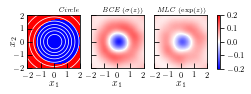

In [403]:
fig, axs = plt.subplots(1, 3, figsize = (3.5, 1), 
                        sharex = True, sharey = True)
axs[0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', zorder = -2)
axs[0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
               linewidths = 0.75, zorder = -1)

axs[0].set_aspect('equal')
axs[0].set_yticks([-2, -1, 0, 1, 2])
axs[0].set_xticks([-2, -2, 0, 1, 2])
axs[0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0].tick_params(direction='in', which='both',length=5)
axs[0].set_title(r'\it Circle', loc = 'right', fontsize = 7, pad = 3.5)
axs[0].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0].set_ylabel(r'$x_2$', labelpad = -3)

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
bce_preds = np.load(filestr + 'preds_1.npy')
dd = (bce_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
bce_plot = axs[1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2)
axs[1].set_aspect('equal')
axs[1].set_yticks([-2, -1, 0, 1, 2])
axs[1].set_xticks([-2, -2, 0, 1, 2])
axs[1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1].tick_params(direction='in', which='both',length=5)
axs[1].set_title(r'{\it BCE} ($\sigma(z)$)', loc = 'right', fontsize = 7,
                 pad = 3.5)
axs[1].set_xlabel(r'$x_1$', labelpad = -0.75)

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
mlc_preds = np.load(filestr + 'preds_3.npy')
dd = (mlc_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
mlc_plot = axs[2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2)
axs[2].set_aspect('equal')
axs[2].set_yticks([-2, -1, 0, 1, 2])
axs[2].set_xticks([-2, -1, 0, 1, 2])
axs[2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2].tick_params(direction='in', which='both',length=5)
axs[2].set_title(r'{\it MLC} ($\exp(z)$)', loc = 'right', fontsize = 7, 
                 pad = 3.5)
axs[2].set_xlabel(r'$x_1$', labelpad = -0.75)

fig.colorbar(mlc_plot, ax = axs.ravel(), fraction = 0.03, 
             ticks = np.arange(-0.2, 0.21, 0.1))

plt.savefig('plots/paper/mvn/circle.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Case 3

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### Hyperbola Plot

For this one, we'll plot MSE and SQR.

In [385]:
num = 3

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

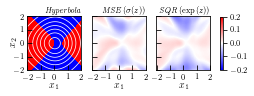

In [401]:
fig, axs = plt.subplots(1, 3, figsize = (3.5, 1), 
                        sharex = True, sharey = True)
axs[0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', zorder = -2)
axs[0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
               linewidths = 0.75, zorder = -1)

axs[0].set_aspect('equal')
axs[0].set_yticks([-2, -1, 0, 1, 2])
axs[0].set_xticks([-2, -2, 0, 1, 2])
axs[0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0].tick_params(direction='in', which='both',length=5)
axs[0].set_title(r'\it Hyperbola', loc = 'right', fontsize = 8, pad = 3.5)
axs[0].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0].set_ylabel(r'$x_2$', labelpad = -3)

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
mse_preds = np.load(filestr + 'preds_1.npy')
dd = (mse_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
mse_plot = axs[1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2)
axs[1].set_aspect('equal')
axs[1].set_yticks([-2, -1, 0, 1, 2])
axs[1].set_xticks([-2, -2, 0, 1, 2])
axs[1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1].tick_params(direction='in', which='both',length=5)
axs[1].set_title(r'{\it MSE} ($\sigma(z)$)', loc = 'right', fontsize = 8, 
                 pad = 3.5)
axs[1].set_xlabel(r'$x_1$', labelpad = -0.75)

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
sqr_preds = np.load(filestr + 'preds_3.npy')
dd = (sqr_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
sqr_plot = axs[2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2)
axs[2].set_aspect('equal')
axs[2].set_yticks([-2, -1, 0, 1, 2])
axs[2].set_xticks([-2, -1, 0, 1, 2])
axs[2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2].tick_params(direction='in', which='both',length=5)
axs[2].set_title(r'{\it SQR} ($\exp(z)$)', loc = 'right', fontsize = 8, 
                 pad = 3.5)
axs[2].set_xlabel(r'$x_1$', labelpad = -0.75)

fig.colorbar(mlc_plot, ax = axs.ravel(), fraction = 0.0135, 
             ticks = np.arange(-0.2, 0.21, 0.1))

plt.savefig('plots/paper/mvn/hyperbola.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Case 4

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

### Bar Chart

In [302]:
bce_avgs = np.zeros((5, 3))
bce_stds = np.zeros((5, 3))
bce_filestr = 'models/multivariate/c_bce/set_{}/'
for i in range(5):
    bce_avgs[i][0] = np.load(bce_filestr.format(i) + 'avg_1.npy')
    bce_avgs[i][1] = np.load(bce_filestr.format(i) + 'avg_2.npy')
    bce_avgs[i][2] = np.load(bce_filestr.format(i) + 'avg_3.npy')
    
    bce_stds[i][0] = np.load(bce_filestr.format(i) + 'std_1.npy') / 10
    bce_stds[i][1] = np.load(bce_filestr.format(i) + 'std_2.npy') / 10
    bce_stds[i][2] = np.load(bce_filestr.format(i) + 'std_3.npy') / 10
    
mse_avgs = np.zeros((5, 3))
mse_stds = np.zeros((5, 3))
mse_filestr = 'models/multivariate/c_mse/set_{}/'
for i in range(5):
    mse_avgs[i][0] = np.load(mse_filestr.format(i) + 'avg_1.npy')
    mse_avgs[i][1] = np.load(mse_filestr.format(i) + 'avg_2.npy')
    mse_avgs[i][2] = np.load(mse_filestr.format(i) + 'avg_3.npy')
    
    mse_stds[i][0] = np.load(mse_filestr.format(i) + 'std_1.npy') / 10
    mse_stds[i][1] = np.load(mse_filestr.format(i) + 'std_2.npy') / 10
    mse_stds[i][2] = np.load(mse_filestr.format(i) + 'std_3.npy') / 10
    
mlc_avgs = np.zeros((5, 3))
mlc_stds = np.zeros((5, 3))
mlc_filestr = 'models/multivariate/c_mlc/set_{}/'
for i in range(5):
    mlc_avgs[i][0] = np.load(mlc_filestr.format(i) + 'avg_1.npy')
    mlc_avgs[i][1] = np.load(mlc_filestr.format(i) + 'avg_2.npy')
    mlc_avgs[i][2] = np.load(mlc_filestr.format(i) + 'avg_3.npy')
    
    mlc_stds[i][0] = np.load(mlc_filestr.format(i) + 'std_1.npy') / 10
    mlc_stds[i][1] = np.load(mlc_filestr.format(i) + 'std_2.npy') / 10
    mlc_stds[i][2] = np.load(mlc_filestr.format(i) + 'std_3.npy') / 10
    
sqr_avgs = np.zeros((5, 3))
sqr_stds = np.zeros((5, 3))
sqr_filestr = 'models/multivariate/c_sqr/set_{}/'
for i in range(5):
    sqr_avgs[i][0] = np.load(sqr_filestr.format(i) + 'avg_1.npy')
    sqr_avgs[i][1] = np.load(sqr_filestr.format(i) + 'avg_2.npy')
    sqr_avgs[i][2] = np.load(sqr_filestr.format(i) + 'avg_3.npy')
    
    sqr_stds[i][0] = np.load(sqr_filestr.format(i) + 'std_1.npy') / 10
    sqr_stds[i][1] = np.load(sqr_filestr.format(i) + 'std_2.npy') / 10
    sqr_stds[i][2] = np.load(sqr_filestr.format(i) + 'std_3.npy') / 10

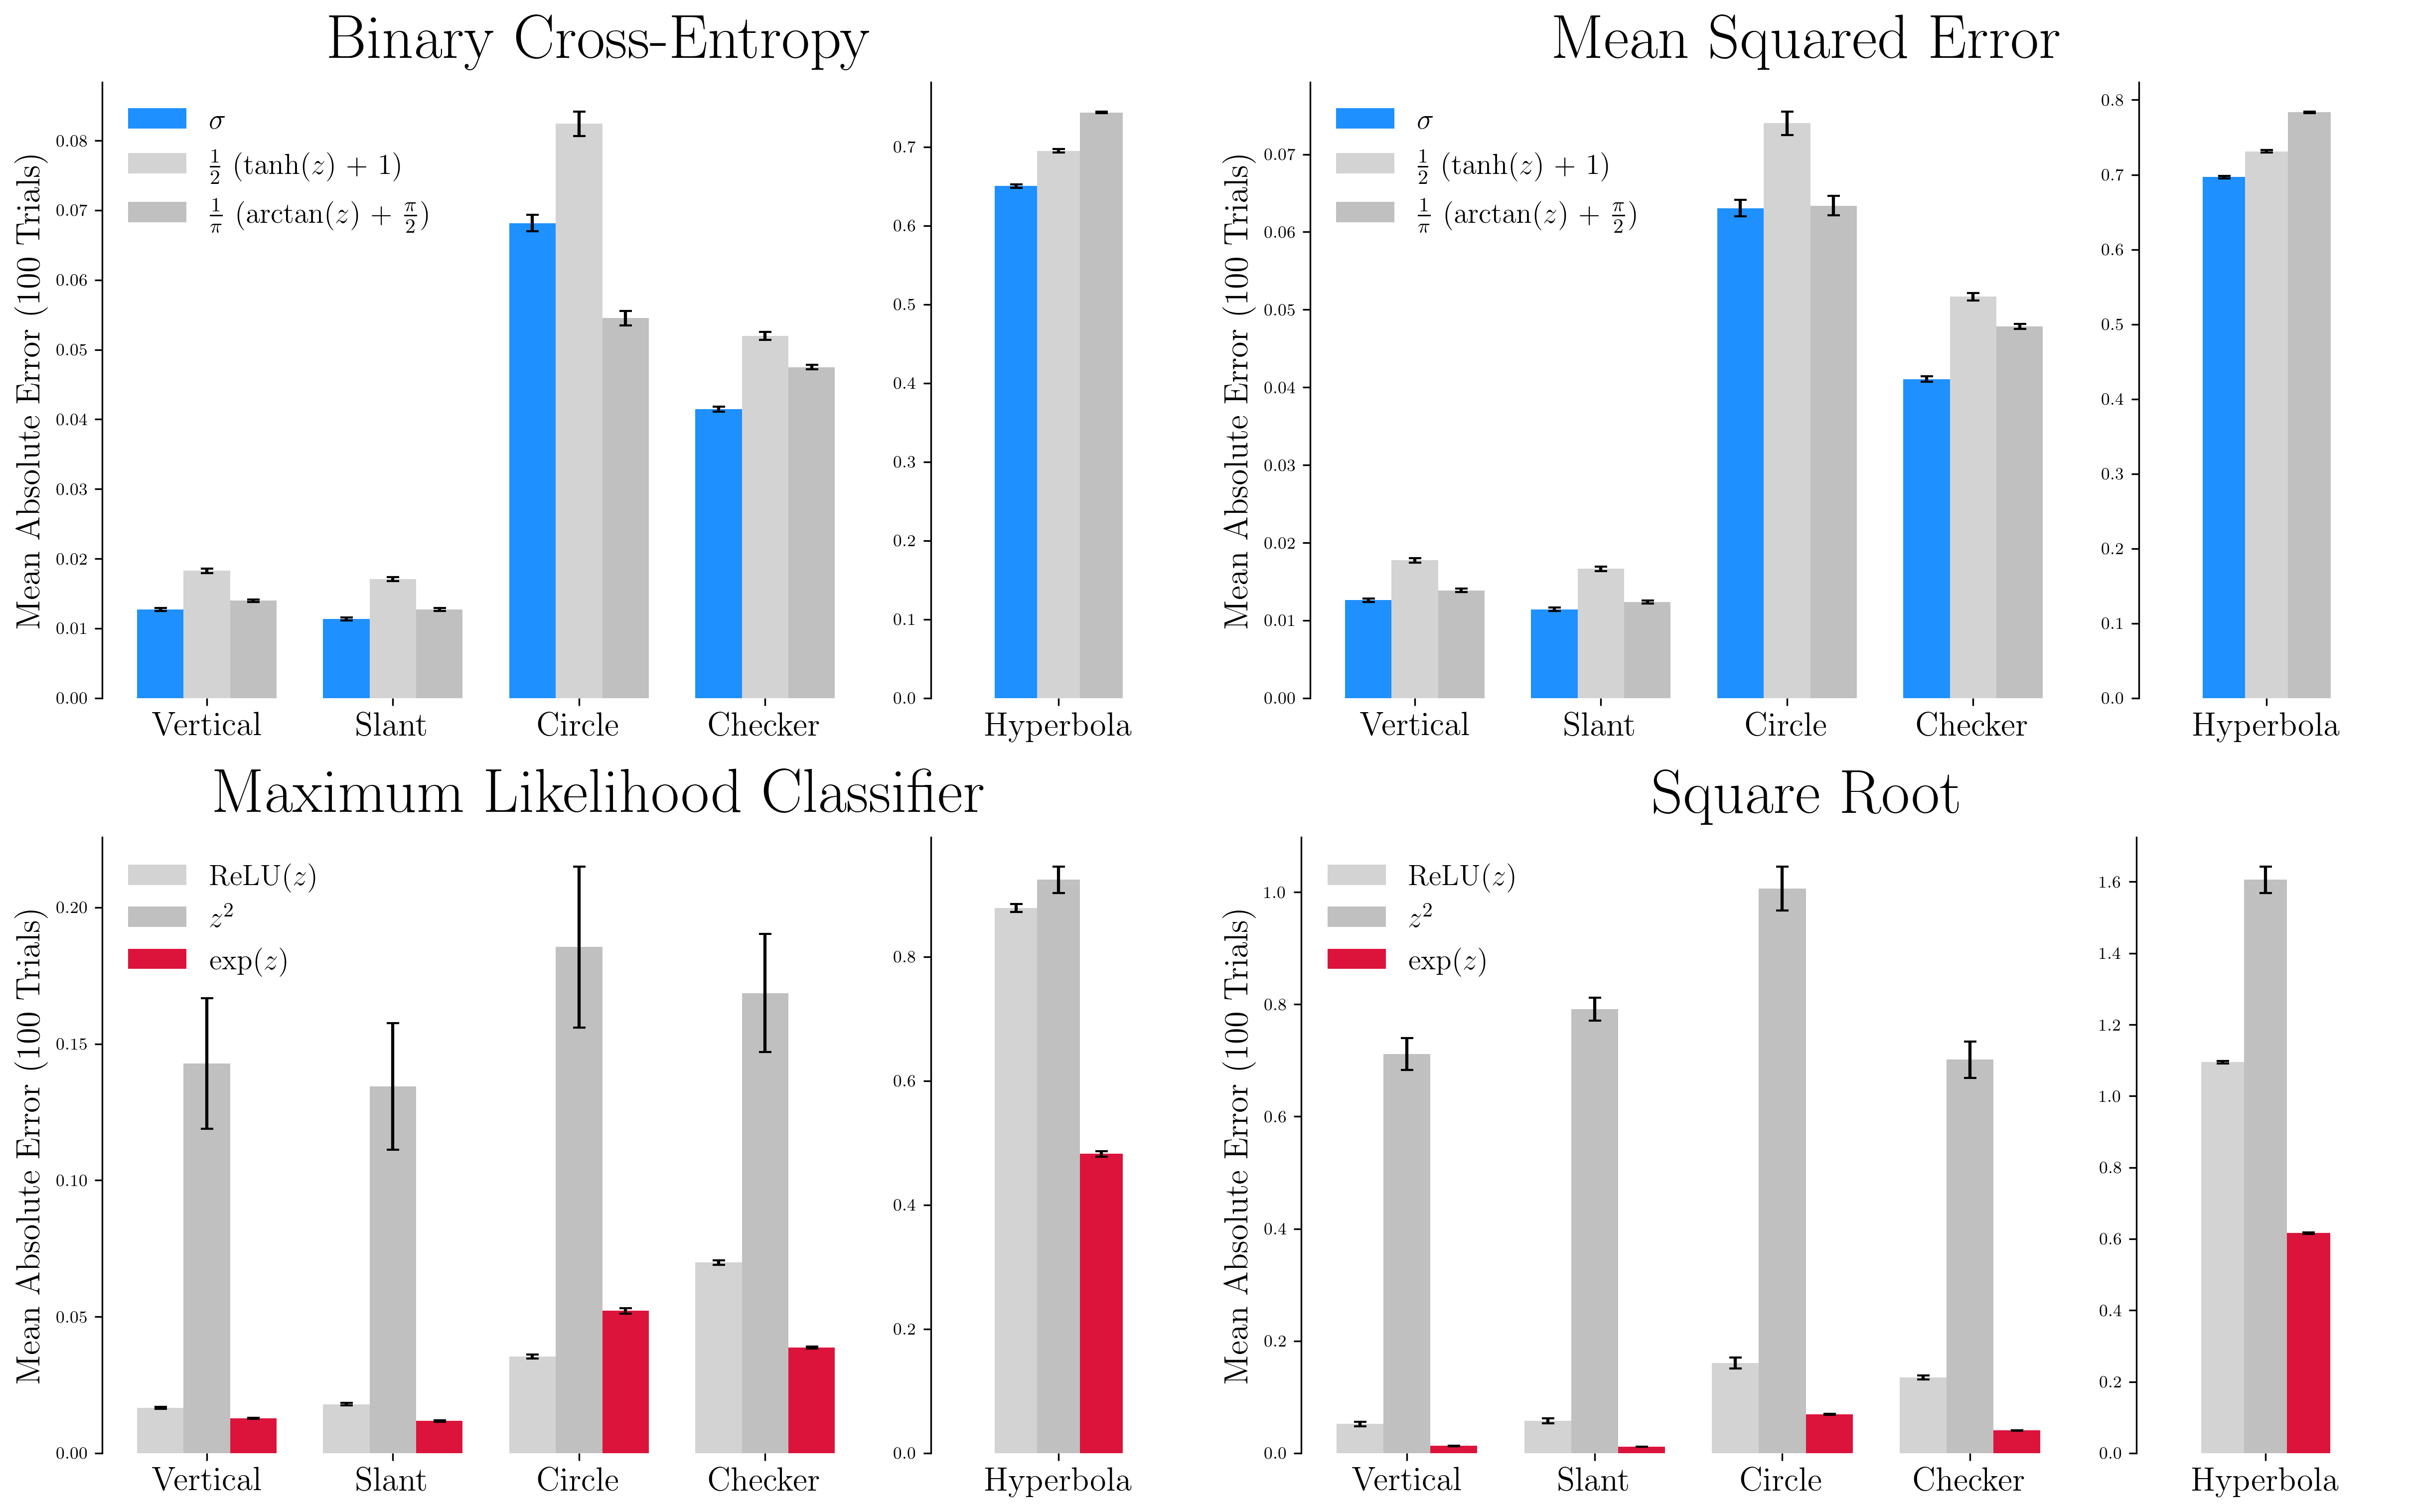

In [305]:
fig = plt.figure(figsize=(16,10), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(2, 2)

barWidth = 0.25

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(nrows=1, ncols=2, gridspec_kw = {'width_ratios': [3,1]})
    
    if outerind == 0: 
        loss = bce_avgs.T
        errs = bce_stds.T
        color1 = 'dodgerblue'
        color2 = 'lightgrey'
        color3 = 'silver'
        title = "Binary Cross-Entropy"
        label1 = r'$\sigma$'
        label2 = r'$\frac{1}{2}$ (tanh($z$) + 1)'
        label3 = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)'
        loc='best'
        
    elif outerind == 1: 
        loss = mse_avgs.T
        errs = mse_stds.T
        color1 = 'dodgerblue'
        color2 = 'lightgrey'
        color3 = 'silver'
        title = "Mean Squared Error"
        label1 = r'$\sigma$'
        label2 = r'$\frac{1}{2}$ (tanh($z$) + 1)'
        label3 = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)'
        loc='best'
        
    elif outerind == 2:
        loss = mlc_avgs.T
        errs = mlc_stds.T
        color1 = 'lightgrey'
        color2 = 'silver'
        color3 = 'crimson'
        title = "Maximum Likelihood Classifier"
        label1 = r'ReLU($z$)'
        label2 = r'$z^2$'
        label3 = r'exp($z$)'
        loc='upper left'
        
    elif outerind == 3:
        loss = sqr_avgs.T
        errs = sqr_stds.T
        color1 = 'lightgrey'
        color2 = 'silver'
        color3 = 'crimson'
        title = "Square Root"
        label1 = r'ReLU($z$)'
        label2 = r'$z^2$'
        label3 = r'exp($z$)'
        loc='upper left'
        
    subfig.suptitle(title, fontsize=30)

    act_0 = loss[0]
    act_1 = loss[1]
    act_2 = loss[2]
    
    err_0 = errs[0]
    err_1 = errs[1]
    err_2 = errs[2]
    
    for innerind, ax in enumerate(axs.flat):
        #ax.set_frame_on(False)
        if innerind == 0: 
            br1 = np.arange(4)
            br2 = [x + barWidth for x in br1]
            br3 = [x + barWidth for x in br2]
            act_0_4 = np.append(act_0[:3], act_0[-1])
            act_1_4 = np.append(act_1[:3], act_1[-1])
            act_2_4 = np.append(act_2[:3], act_2[-1])
            
            err_0_4 = np.append(err_0[:3], err_0[-1])
            err_1_4 = np.append(err_1[:3], err_1[-1])
            err_2_4 = np.append(err_2[:3], err_2[-1])
            ax.bar(br1, act_0_4, color = color1, width = barWidth, label =label1)
            ax.errorbar(br1, act_0_4, yerr=err_0_4, color='black', capsize=3, linestyle='none')        
            ax.bar(br2, act_1_4, color =color2, width = barWidth, label =label2)
            ax.errorbar(br2, act_1_4, yerr=err_1_4, color='black', capsize=3, linestyle='none')   
            ax.bar(br3, act_2_4, color =color3, width = barWidth, label = label3)
            ax.errorbar(br3, act_2_4, yerr=err_2_4, color='black', capsize=3, linestyle='none')  
            ax.set_xticks([r + barWidth for r in range(4)], ['Vertical', 'Slant', 'Circle', 'Checker'], fontsize=16, rotation=0)    
            ax.legend(fontsize=14, loc=loc, frameon=False);
            ax.set_ylabel('Mean Absolute Error (100 Trials)',  fontsize = 16)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
        else: 
            br1 = np.arange(1)
            br2 = [x + barWidth for x in br1]
            br3 = [x + barWidth for x in br2]
            ax.bar(br1, act_0[3], color = color1, width = barWidth)
            ax.errorbar(br1, act_0[3], yerr=err_0[3], color='black', capsize=3, linestyle='none')      
            ax.bar(br2, act_1[3], color = color2, width = barWidth)
            ax.errorbar(br2, act_1[3], yerr=err_1[3], color='black', capsize=3, linestyle='none')   
            ax.bar(br3, act_2[3], color =color3, width = barWidth, )
            ax.errorbar(br3, act_2[3], yerr=err_2[3], color='black', capsize=3, linestyle='none')  
            ax.set_xticks([0+barWidth],['Hyperbola'], fontsize=16, rotation=0)
            ax.set_xlim([-0.5,1])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
plt.savefig('plots/paper/mvn/mvn_losses.pdf')

## $A/B$ Parametrization

### Case 0

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 1

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_slant.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_slant.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 2

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_circle.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_circle.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 3

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 4

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_checker.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 2, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 2, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_checker.png', 
            dpi=300, 
            bbox_inches='tight')

# Physics Data

## Variable Histograms

In [180]:
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_y  = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

data = np.load("data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")
dat_pt =  data['sim_jets'][:, 0]
dat_y  = data['sim_jets'][:, 1]
dat_phi = data['sim_jets'][:, 2]
dat_m =   data['sim_jets'][:, 3]

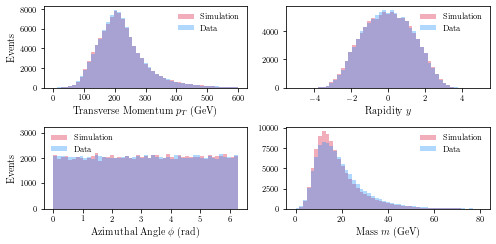

In [244]:
fig, axs = plt.subplots(2, 2, figsize = (7, 3.5))

bins = np.linspace(0, 600, 50)
axs[0, 0].hist(sim_pt, bins = bins, alpha = 0.35, color = 'crimson', label = 'Simulation')
axs[0, 0].hist(dat_pt, bins = bins, alpha = 0.35, color = 'dodgerblue', label = 'Data')
axs[0, 0].set_ylabel('Events')
axs[0, 0].set_xlabel(r'Transverse Momentum $p_T$ (GeV)')
axs[0, 0].legend(frameon = False)

bins = np.linspace(-5, 5, 50)
axs[0, 1].hist(sim_y, bins = bins, alpha = 0.35, color = 'crimson', label = 'Simulation')
axs[0, 1].hist(dat_y, bins = bins, alpha = 0.35, color = 'dodgerblue', label = 'Data')
#axs[0, 1].set_ylabel('Events')
axs[0, 1].set_xlabel(r'Rapidity $y$')
axs[0, 1].legend(frameon = False)

bins = np.linspace(0, 2*np.pi, 50)
axs[1, 0].hist(sim_phi, bins = bins, alpha = 0.35, color = 'crimson', label = 'Simulation')
axs[1, 0].hist(dat_phi, bins = bins, alpha = 0.35, color = 'dodgerblue', label = 'Data')
axs[1, 0].set_ylim(0, 3200)
axs[1, 0].set_ylabel('Events')
axs[1, 0].set_xlabel(r'Azimuthal Angle $\phi$ (rad)')
axs[1, 0].legend(frameon = False)

bins = np.linspace(0, 80, 50)
axs[1, 1].hist(sim_m, bins = bins, alpha = 0.35, color = 'crimson', label = 'Simulation')
axs[1, 1].hist(dat_m, bins = bins, alpha = 0.35, color = 'dodgerblue', label = 'Data')
#axs[1, 1].set_ylabel('Events')
axs[1, 1].set_xlabel(r'Mass $m$ (GeV)')
axs[1, 1].legend(frameon = False)

fig.tight_layout()

plt.savefig('plots/paper/physics/dists.pdf',
            bbox_inches = 'tight')

## Scans

In [18]:
d = 4

dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/dat6/ckpt-235')
sim_ckpt.restore('flows/sim3/ckpt-235')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

2023-03-28 00:08:38.305524: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 00:08:38.923442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22824 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


In [19]:
X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')

In [20]:
stats.mode(X)

ModeResult(mode=array([[218.1418   ,  -2.0407841,   4.4148946,  22.070618 ]],
      dtype=float32), count=array([[9, 6, 8, 9]]))

In [21]:
mode_pT = 218
mode_eta = 0
mode_phi = 4.4
mode_m = 22

### $\phi$ Scan

In [25]:
# Get a one-dimensional slice of test points.
phis = np.linspace(0, 2*np.pi, 1201).reshape(-1, 1)
pTs = np.repeat(mode_pT, len(phis)).reshape(-1, 1)
etas = np.repeat(mode_eta, len(phis)).reshape(-1, 1)
ms = np.repeat(mode_m, len(phis)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = phis
var_label = r'$\phi$'
var_string = 'phi'

lr_true = lr(xs)

#### BCE

In [95]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

In [96]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [97]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 2)
title = r'{\it BCE Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/bce_phi.pdf'

In [98]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

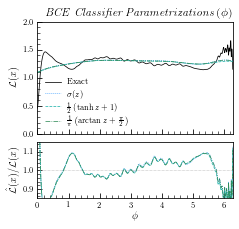

In [99]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### MSE

In [100]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

In [101]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [102]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 2)
title = r'{\it MSE Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/mse_phi.pdf'

In [103]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

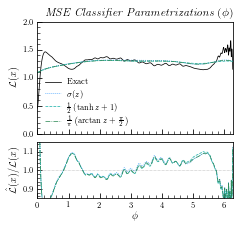

In [104]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### MLC

In [105]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

In [106]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [107]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 2)
title = r'{\it MLC Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/mlc_phi.pdf'

In [108]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

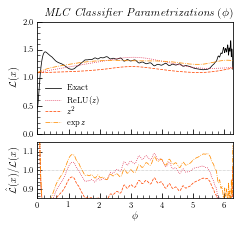

In [109]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### SQR

In [110]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

In [122]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [126]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 2)
title = r'{\it SQR Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/sqr_phi.pdf'

In [158]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

lrs[1] = preds_2.mean(axis = 0, where = ~np.isnan(preds_2))

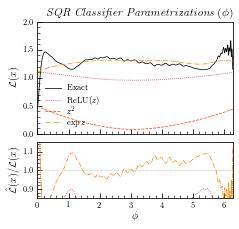

In [159]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## Bar Chart

In [307]:
bce_avgs = np.zeros(3)
bce_stds = np.zeros(3)
bce_filestr = 'models/zenodo/c_bce/set_0/'
for i in range(3):
    bce_avgs[i] = np.load(bce_filestr + 'avg_{}.npy'.format(i + 1))
    bce_stds[i] = np.load(bce_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/zenodo/c_mse/set_0/'
for i in range(3):
    mse_avgs[i] = np.load(mse_filestr + 'avg_{}.npy'.format(i + 1))
    mse_stds[i] = np.load(mse_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/zenodo/c_mlc/set_0/'
for i in range(3):
    mlc_avgs[i] = np.load(mlc_filestr + 'avg_{}.npy'.format(i + 1))
    mlc_stds[i] = np.load(mlc_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/zenodo/c_sqr/set_0/'
for i in range(3):
    sqr_avgs[i] = np.load(sqr_filestr + 'avg_{}.npy'.format(i + 1))
    sqr_stds[i] = np.load(sqr_filestr + 'std_{}.npy'.format(i + 1)) / 10

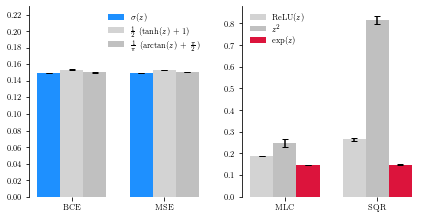

In [309]:
fig, axs = plt.subplots(1, 2, figsize = (7, 3.5))
width = 0.25

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].bar(0, bce_avgs[0], width = width, color = 'dodgerblue', label = r'$\sigma(z)$')
axs[0].errorbar(0, bce_avgs[0], yerr = bce_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + width, bce_avgs[1], width = width, color = 'lightgrey', label = r'$\frac{1}{2}$ (tanh($z$) + 1)')
axs[0].errorbar(0 + width, bce_avgs[1], yerr = bce_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 2*width, bce_avgs[2], width = width, color = 'silver', label = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)')
axs[0].errorbar(0 + 2*width, bce_avgs[2], yerr = bce_stds[2], color = 'black', capsize=3, linestyle='none')

axs[0].bar(0 + 4*width, mse_avgs[0], width = width, color = 'dodgerblue')
axs[0].errorbar(0 + 4*width, mse_avgs[0], yerr = mse_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 5*width, mse_avgs[1], width = width, color = 'lightgrey')
axs[0].errorbar(0 + 5*width, mse_avgs[1], yerr = mse_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 6*width, mse_avgs[2], width = width, color = 'silver')
axs[0].errorbar(0 + 6*width, mse_avgs[2], yerr = mse_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[0].set_ylim(0, 0.23)
axs[0].set_yticks(np.arange(0, 0.23, 0.02))
axs[0].legend(frameon=False, loc = 'best')
axs[0].set_xticks([width, 5*width], ['BCE', 'MSE'])


axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].bar(0, mlc_avgs[0], width = width, color = 'lightgrey', label = r'ReLU($z$)')
axs[1].errorbar(0, mlc_avgs[0], yerr = mlc_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + width, mlc_avgs[1], width = width, color = 'silver', label = r'$z^2$')
axs[1].errorbar(0 + width, mlc_avgs[1], yerr = mlc_stds[1], color = 'black', capsize=3, linestyle='none')
axs[1].bar(0 + 2*width, mlc_avgs[2], width = width, color = 'crimson', label = r'$\exp(z)$')
axs[1].errorbar(0 + 2*width, mlc_avgs[2], yerr = mlc_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(frameon=False)

axs[1].bar(0 + 4*width, sqr_avgs[0], width = width, color = 'lightgrey')
axs[1].errorbar(0 + 4*width, sqr_avgs[0], yerr = sqr_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 5*width, sqr_avgs[1], width = width, color = 'silver')
axs[1].errorbar(0 + 5*width, sqr_avgs[1], yerr = sqr_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 6*width, sqr_avgs[2], width = width, color = 'crimson')
axs[1].errorbar(0 + 6*width, sqr_avgs[2], yerr = sqr_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(frameon=False, loc = 'best')
axs[1].set_xticks([width, 5*width], ['MLC', 'SQR'])

plt.savefig('plots/paper/physics/physics_losses.pdf', dpi = 300, bbox_inches = 'tight')

# Trees

## Vertical

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
N = 10**6
X = np.load('data/trees/X_trn.npy')[:N]
y = np.load('data/trees/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# Load in models.
bce_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)

xs = np.linspace(-6, 6, 1201)

bce_preds = get_preds(bce_lrs, xs)

# BDT model
bdt = XGBClassifier(early_stopping_rounds = 10)
bdt.load_model(bdt_filestr.format(N, 0))
bdt_lr = xgb_lr(bdt, m, s)

bdt_preds = bdt_lr(xs)

In [ ]:
np.save(filestr + 'xs', xs)
np.save(filestr + 'bce_preds', bce_preds)
np.save(filestr + 'bdt_preds', bdt_preds)

#### Plot

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 16$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 32$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avd', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plots

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

## Slant

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 16$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 32$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')

    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

## Zenodo

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat1/ckpt-157')
sim_ckpt.restore('flows/zenodo/sim1/ckpt-157')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-157'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-157'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-157'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-157'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-157'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-157'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7:
        reps = 36
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 11$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat1/ckpt-157')
sim_ckpt.restore('flows/zenodo/sim1/ckpt-157')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7:
        reps = 36
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))